In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import cm
# from distfit import distfit
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [4]:
future_data = pd.read_csv("./data/futures.csv")
future_data['SOFR_rate'] = (100 - future_data['MID_PRICE'])/100
future_data['Timestamp'] = future_data['Timestamp'].str[:10]
future_exp_list = sorted(list(future_data['Expiration'].unique()))

option_data = pd.read_csv("./data/options.csv")
option_data['Timestamp'] = option_data['Timestamp'].str[:10]
option_exp_list = sorted(list(option_data['Expiration'].unique()))
# ts_list = sorted(list(option_data['Timestamp'].unique()))

sofr = pd.read_excel("./data/Overnight_SOFR.xlsx")
daily_sofr = sofr.iloc[:,[0,2]]
daily_sofr.columns = ['Date','SOFR_Rate']
daily_sofr.loc[:,'Date'] = daily_sofr.loc[:,'Date'].apply(lambda x:x[-4:]+'-'+x[:2]+'-'+x[3:5])
daily_sofr = daily_sofr.sort_values(by='Date').set_index('Date')

fed_sample = pd.read_csv("./data/rate_curve/FEDDecisionDist_20230103150000.csv",index_col=0)
fed_meeting_date = list(fed_sample.index)
fed_meeting_date
# daily_rate = pd.read_csv("../data/rate_curve/BucketRate_20230103150000.csv")

['2023-02-01',
 '2023-03-22',
 '2023-05-03',
 '2023-06-14',
 '2023-07-26',
 '2023-09-20',
 '2023-11-01',
 '2023-12-13']

In [5]:
def objective_function(params):
    sigma,w1,w2 = params
    sigma_1 = sigma
    sigma_2 = sigma
    sigma_3 = sigma
    w3 = 1-w1-w2
    F = atm_price
    mse_res = 0.
    for i in range(len(otm_price)):
        k = otm_price.index[i]
        real_price = otm_price.iloc[i].values[0]
        
        if F<=k:
            d1 = (F-k)/(sigma_1*np.sqrt(ttm))
            call_price_1 = discount*((F-k)*norm.cdf(d1+mu_1,mu_1,1.)+
                                     sigma_1*np.sqrt(ttm)*norm.pdf(d1+mu_1,mu_1,1.))

            d2 = (F-k)/(sigma_2*np.sqrt(ttm))
            call_price_2 = discount*((F-k)*norm.cdf(d2+mu_2,mu_2,1.)+
                                     sigma_2*np.sqrt(ttm)*norm.pdf(d2+mu_2,mu_2,1.))

            d3 = (F-k)/(sigma_3*np.sqrt(ttm))
            call_price_3 = discount*((F-k)*norm.cdf(d3+mu_3,mu_3,1.)+
                                     sigma_3*np.sqrt(ttm)*norm.pdf(d3+mu_3,mu_3,1.))

            call_price = w1*call_price_1+w2*call_price_2+w3*call_price_3
            mse_res += (call_price-real_price)**2
        elif F>k:
            d1 = (F-k)/(sigma_1*np.sqrt(ttm))
            put_price_1 = discount*((k-F)*norm.cdf(-d1-mu_1,mu_1,1.)+
                                    sigma_1*np.sqrt(ttm)*norm.pdf(d1+mu_1,mu_1,1.))

            d2 = (F-k)/(sigma_2*np.sqrt(ttm))
            put_price_2 = discount*((k-F)*norm.cdf(-d2-mu_2,mu_2,1.)+
                                    sigma_2*np.sqrt(ttm)*norm.pdf(d2+mu_2,mu_2,1.))

            d3 = (F-k)/(sigma_3*np.sqrt(ttm))
            put_price_3 = discount*((k-F)*norm.cdf(-d3-mu_3,mu_3,1.)+
                                    sigma_3*np.sqrt(ttm)*norm.pdf(d3+mu_3,mu_3,1.))

            put_price = w1*put_price_1+w2*put_price_2+w3*put_price_3
            mse_res += (put_price-real_price)**2
    return mse_res/len(otm_price)

def constraint_1(params):
    sigma,w1,w2 = params
    w3 = 1-w1-w2
    return w1*mu_1+w2*mu_2+w3*mu_3-atm_price  

def pricng_function(otm_price,params):
    sigma,w1,w2 = params
    sigma_1 = sigma
    sigma_2 = sigma
    sigma_3 = sigma
    w3 = 1-w1-w2
    F = atm_price
    mse_res = 0.
    for i in range(len(otm_price)):
        k = otm_price.index[i]
        real_price = otm_price.iloc[i].values[0]
        
        if F<=k:
            d1 = (F-k)/(sigma_1*np.sqrt(ttm))
            call_price_1 = discount*((F-k)*norm.cdf(d1+mu_1,mu_1,1.)+
                                     sigma_1*np.sqrt(ttm)*norm.pdf(d1+mu_1,mu_1,1.))

            d2 = (F-k)/(sigma_2*np.sqrt(ttm))
            call_price_2 = discount*((F-k)*norm.cdf(d2+mu_2,mu_2,1.)+
                                     sigma_2*np.sqrt(ttm)*norm.pdf(d2+mu_2,mu_2,1.))

            d3 = (F-k)/(sigma_3*np.sqrt(ttm))
            call_price_3 = discount*((F-k)*norm.cdf(d3+mu_3,mu_3,1.)+
                                     sigma_3*np.sqrt(ttm)*norm.pdf(d3+mu_3,mu_3,1.))

            call_price_ = w1*call_price_1+w2*call_price_2+w3*call_price_3
            otm_price.loc[k,'Theo_Price'] = call_price_
        elif F>k:
            d1 = (F-k)/(sigma_1*np.sqrt(ttm))
            put_price_1 = discount*((k-F)*norm.cdf(-d1-mu_1,mu_1,1.)+
                                    sigma_1*np.sqrt(ttm)*norm.pdf(d1+mu_1,mu_1,1.))

            d2 = (F-k)/(sigma_2*np.sqrt(ttm))
            put_price_2 = discount*((k-F)*norm.cdf(-d2-mu_2,mu_2,1.)+
                                    sigma_2*np.sqrt(ttm)*norm.pdf(d2+mu_2,mu_2,1.))

            d3 = (F-k)/(sigma_3*np.sqrt(ttm))
            put_price_3 = discount*((k-F)*norm.cdf(-d3-mu_3,mu_3,1.)+
                                    sigma_3*np.sqrt(ttm)*norm.pdf(d3+mu_3,mu_3,1.))

            put_price_ = w1*put_price_1+w2*put_price_2+w3*put_price_3
            otm_price.loc[k,'Theo_Price'] = put_price_
    return otm_price

constraints = ({'type': 'eq', 'fun': constraint_1})
param_bounds = [(0,1),(0,1),(0,1)]
otm_price_list = []
param_df = pd.DataFrame()

In [6]:
exp_index = 2
contract_data = option_data[option_data['Expiration']==option_exp_list[exp_index]]
contract_data_call = contract_data[contract_data['AssetTypeName']=='Calls'].reset_index(drop=True)# .sort_values(by='StrikePrice')
contract_data_put = contract_data[contract_data['AssetTypeName']=='Puts'].reset_index(drop=True)# .sort_values(by='StrikePrice')
ts_list = sorted(list(contract_data['Timestamp'].unique()))
exp_date = option_exp_list[exp_index]
option_exp = option_exp_list[exp_index]
future_exp = str(pd.to_datetime(option_exp)+pd.Timedelta(days=90))[:10]
for d in future_exp_list:
    if d>=future_exp:
        future_exp = d
        break
print("Contract Expiration: {}, Future Expiration: {}".format(exp_date,future_exp))
print("Date Range: {} to {}, Date Length: {}".format(ts_list[0],ts_list[-1],len(ts_list)))

Contract Expiration: 2023-03-10, Future Expiration: 2023-06-20
Date Range: 2023-01-03 to 2023-03-09, Date Length: 46


In [7]:
otm_df_list = []
# 1. price monotonous
for j in range(len(ts_list)):
    ## CALL RES
    otm_df = pd.DataFrame()
    ts = ts_list[j]
    atm_price = future_data.loc[(future_data['Timestamp']==ts)&(future_data['Expiration']==future_exp),'MID_PRICE'].values
    if len(atm_price)>0:
        atm_price = atm_price[0]
        contract_data_call_smooth = contract_data_call.copy()
        call_res_df = pd.DataFrame()
        part_data_call = contract_data_call_smooth[contract_data_call_smooth['Timestamp']==ts].sort_values(by='StrikePrice').reset_index()
        otm_call = part_data_call[part_data_call['StrikePrice']>=atm_price].set_index('StrikePrice')[['MICRO_PRICE','BIDPRICE0','ASKPRICE0']]

        ## PUT RES
        contract_data_put_smooth = contract_data_put.copy()
        put_res_df = pd.DataFrame()
        part_data_put = contract_data_put_smooth[contract_data_put_smooth['Timestamp']==ts].sort_values(by='StrikePrice').reset_index()
        otm_put = part_data_put[part_data_put['StrikePrice']<=atm_price].set_index('StrikePrice')[['MICRO_PRICE','BIDPRICE0','ASKPRICE0']]

        ## TOTAL RES
        if len(otm_call)==0 and len(otm_put)==0:
            print("{} Missing".format(ts))
            continue
        else:
            total_res = pd.concat([otm_put, otm_call])
#             total_res.columns = ['{}_OTM_PRICE'.format(ts)]
            otm_df = pd.merge(otm_df, total_res, how='outer', left_index=True, right_index=True)
    otm_df_list.append(otm_df)
print("Contract Expiration: {}".format(exp_date))
otm_df
# otm_df.plot(color=cm.viridis(np.linspace(0,3,len(otm_df)))).legend(bbox_to_anchor=(1.1, 1))

Contract Expiration: 2023-03-10


,MICRO_PRICE,BIDPRICE0,ASKPRICE0
StrikePrice,,,
94.8125,0.0175,0.0075,0.0175
94.8750,0.0468,0.0350,0.0500
94.9375,0.0238,0.0225,0.0300
95.0000,0.0059,0.0025,0.0075


## Optimize multi normal dist

In [10]:
for i in range(len(ts_list)):
    try:
        ts_index = i
        ts = ts_list[ts_index]
        atm_price = future_data.loc[(future_data['Timestamp']==ts)&(future_data['Expiration']==future_exp),
                                    'MID_PRICE'].values[0]

        date1 = datetime.strptime(exp_date, '%Y-%m-%d')
        date2 = datetime.strptime(ts, '%Y-%m-%d')
        date_difference = date1 - date2
        ttm = date_difference.days
        discount = np.exp(-0.04*ttm/365)
        ttm = ttm/365

        otm_price = otm_df_list[i]
        otm_price = otm_price.dropna()
#         otm_price.columns = ['Real_Price']

        fed_prob = pd.read_csv("./data/rate_curve/FEDDecisionDist_{}150000.csv".format(ts.replace('-','')),
                               index_col=0)
        terminal_prob = fed_prob.iloc[1]
        terminal_prob = terminal_prob[terminal_prob>0.]
        current_sofr = daily_sofr.loc[ts].values[0]

        mu_1 = 100-(current_sofr+float(terminal_prob.index[0])*100)
        mu_2 = 100-(current_sofr+float(terminal_prob.index[1])*100)
        mu_3 = 100-(current_sofr+float(terminal_prob.index[2])*100)

        initial_guess = [0.1,0.3,0.3]

        result = minimize(objective_function, initial_guess,bounds=param_bounds,
                          options={'maxiter': 1000}, constraints=constraints, method='SLSQP')
        otm_price = pricng_function(otm_price,result.x)
        otm_price_list.append(otm_price)
        
        
        param_df.loc[ts,'ttm'] = ttm*365
        param_df.loc[ts,'current_sofr'] = current_sofr
        param_df.loc[ts,'future_price'] = atm_price

        param_df.loc[ts,'FED_prob_{}'.format(terminal_prob.index[0])] = list(terminal_prob)[0]
        param_df.loc[ts,'FED_prob_{}'.format(terminal_prob.index[1])] = list(terminal_prob)[1]
        param_df.loc[ts,'FED_prob_{}'.format(terminal_prob.index[2])] = list(terminal_prob)[2]

        param_df.loc[ts,'mu_1'] = mu_1
        param_df.loc[ts,'mu_2'] = mu_2
        param_df.loc[ts,'mu_3'] = mu_3


        param_df.loc[ts,'sigma'] = result.x[0]

        param_df.loc[ts,'w_1'] = result.x[1]
        param_df.loc[ts,'w_2'] = result.x[2]
        param_df.loc[ts,'w_3'] = 1-result.x[1]-result.x[2]
        param_list.append(param_df)
        otm_price.plot()
    except:
        print("{} Missing".format(ts_list[i]))

2023-01-03 Missing
2023-01-04 Missing
2023-01-05 Missing
2023-01-06 Missing
2023-01-09 Missing
2023-01-10 Missing
2023-01-11 Missing
2023-01-12 Missing
2023-01-13 Missing
2023-01-17 Missing
2023-01-18 Missing
2023-01-19 Missing
2023-01-20 Missing
2023-01-23 Missing
2023-01-24 Missing
2023-01-25 Missing
2023-01-26 Missing
2023-01-27 Missing
2023-01-30 Missing
2023-01-31 Missing
2023-02-01 Missing
2023-02-02 Missing
2023-02-03 Missing
2023-02-06 Missing
2023-02-07 Missing
2023-02-08 Missing
2023-02-09 Missing
2023-02-10 Missing
2023-02-13 Missing
2023-02-14 Missing
2023-02-15 Missing
2023-02-16 Missing
2023-02-17 Missing
2023-02-21 Missing
2023-02-22 Missing
2023-02-23 Missing
2023-02-24 Missing
2023-02-27 Missing
2023-02-28 Missing
2023-03-01 Missing
2023-03-02 Missing
2023-03-03 Missing
2023-03-06 Missing
2023-03-07 Missing
2023-03-08 Missing
2023-03-09 Missing


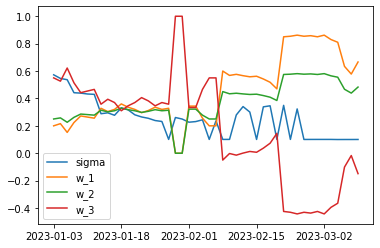

In [13]:
param_df[['sigma','w_1','w_2','w_3']].plot()

In [12]:
param_df

,ttm,current_sofr,future_price,FED_prob_0.0025,FED_prob_0.005,FED_prob_0.0075,mu_1,mu_2,mu_3,sigma,w_1,w_2,w_3,FED_prob_-0.0,FED_prob_0.0,FED_prob_0.01
2023-01-03,66.0,4.33,95.0825,0.1510,0.5711,0.2779,95.42,95.17,94.92,0.5725,2.0000e-01,2.5000e-01,0.550,NaN,NaN,NaN
2023-01-04,65.0,4.33,95.0925,0.1426,0.5788,0.2785,95.42,95.17,94.92,0.5460,2.1600e-01,2.5800e-01,0.526,NaN,NaN,NaN
2023-01-05,64.0,4.33,95.0525,0.0902,0.5287,0.3810,95.42,95.17,94.92,0.5367,1.5200e-01,2.2600e-01,0.622,NaN,NaN,NaN
2023-01-06,63.0,4.33,95.0975,0.1321,0.6258,0.2421,95.42,95.17,94.92,0.4417,2.2400e-01,2.6200e-01,0.514,NaN,NaN,NaN
2023-01-09,60.0,4.33,95.1275,0.1603,0.6358,0.2039,95.42,95.17,94.92,0.4388,2.7200e-01,2.8600e-01,0.442,NaN,NaN,NaN
2023-01-10,59.0,4.33,95.1225,0.1722,0.6238,0.2040,95.42,95.17,94.92,0.4324,2.6400e-01,2.8200e-01,0.454,NaN,NaN,NaN
2023-01-11,58.0,4.33,95.1175,0.1704,0.6068,0.2228,95.42,95.17,94.92,0.4299,2.5600e-01,2.7800e-01,0.466,NaN,NaN,NaN
2023-01-12,57.0,4.33,95.1625,0.2279,0.6867,0.0854,95.42,95.17,94.92,0.2884,3.2800e-01,3.1400e-01,0.358,NaN,NaN,NaN
2023-01-13,56.0,4.33,95.1475,0.1920,0.7085,0.0995,95.42,95.17,94.92,0.2950,3.0400e-01,3.0200e-01,0.394,NaN,NaN,NaN
2023-01-17,52.0,4.33,95.1575,0.1997,0.7059,0.0944,95.42,95.17,94.92,0.2771,3.2000e-01,3.1000e-01,0.370,NaN,NaN,NaN


In [262]:
25*0.151+50*0.5711+75*0.2779

53.1725

base price = future_price - prob weighted/ prob weight 

计算mu用减去bias的price再加25 50 75
prob作为weight确定，会议看1-3月的，不用管t accumulate
sigma唯一参数